In [1]:
import numpy as np
from scipy.sparse import identity
import numpy as np
from scipy import sparse
from scipy.sparse import lil_matrix
import scipy.sparse.linalg
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.quantum_info.operators import Operator
import sys
from qiskit import*
from qiskit import Aer
import qiskit.quantum_info as qi
import numpy as np
import re
from scipy.sparse import identity
import numpy as np
from scipy import sparse
from scipy.sparse import lil_matrix
import scipy.sparse.linalg

In [58]:
def Rz_matrix(theta):

    return np.matrix([[np.exp(-1j*theta/2),0],[0,np.exp(1j*theta/2)]])

def Ry_matrix(theta):

    return np.matrix([[np.cos(theta/2), -np.sin(theta/2)],[np.sin(theta/2),np.cos(theta/2)]])

def Phase_matrix(alpha):
    
    return np.matrix([[np.exp(alpha*1j),0],[0,np.exp(alpha*1j)]])

In [114]:
def CNOT_qiskit(c,t):
    ## Changing the simulator 
    backend = Aer.get_backend('unitary_simulator')

    ## The circuit without measurement
    circ = QuantumCircuit(N)
    circ.cx(c,t)

    ## job execution and getting the result as an object
    job = execute(circ, backend)
    result = job.result()

    ## get the unitary matrix from the result object
    return np.matrix(result.get_unitary(circ))

In [105]:
'''
Qiskit uses little endian notation, where the arrangement of the qubits are reversed.
The Kronecker product for the CNOT gate is modified according to the qiskit notation.
Counting starts from 0 and goes to N-1.

'''
def CNOT(c,t):
    
    '''
    Creating the matrix PI0 (|0><0|) and PI1 (|1><1|).
    
    '''
    I = np.identity(2)
    Z = np.matrix([[1,0],[0,-1]])
    X = np.matrix([[0,1],[1,0]])
    PI_0 = (I+Z)/2
    PI_1 = (I-Z)/2
    
    '''
    The following function returns the X gate for theta = pi. Any deviation from pi will
    result in a slightly different gate, which is used to model the noisy X gate.
    
    '''
    #def Rx(theta):
        #return np.around((np.cos(theta/2)*I-1j*X*np.sin(theta/2))*(np.cos(theta/2)*I+1j*I*np.sin(theta/2)),12)
    
    
    Matrices = {'I':I,'PI_0':PI_0,'X':X, 'PI_1':PI_1}
    
    
    '''
    
    We will first create two lists p0 and p1 (for PI0 and PI1) with the matrices
    of the Kronecker product of PI0 and PI1.
    
    '''
    p0 = ['I']*N
    p1 = ['I']*N
    
    
    '''
    The string will be modified according to the position of the target and the control qubits.
    
    '''
    
    p0[c] = 'PI_0'
    p1[c] = 'PI_1'
    p1[t] = 'X'

    

    '''  
    Initialize the PI0 and PI1 matrices as the first elemenst of the list p0 and p1,
    then the following loop will perform the Kronecker product.
    
    '''    
    
    
    
    PI_0_matrix = Matrices[p0[0]]
    for i in range(1,N):
        PI_0_matrix = sparse.kron(Matrices[p0[i]],PI_0_matrix)
        
    PI_1_matrix = Matrices[p1[0]]
    for i in range(1,N):
        PI_1_matrix = sparse.kron(Matrices[p1[i]],PI_1_matrix)

    return PI_0_matrix+PI_1_matrix

In [579]:
def T_matrix():
    return np.matrix([[1,0],[0,np.exp(1j*np.pi/4)]])

def TDAG_matrix(): 
    return np.matrix([[1,0],[0,np.exp(-1j*np.pi/4)]])

def T(Qubit):
    
    if Qubit > N -1 :
        
        print("Qubit number exceeds N")
        
    else:    
    
        qubits_list = []
    
        for i in range(N):
        
            if i == Qubit:
            
                qubits_list.append(T_matrix())
            
            else:
            
                qubits_list.append(np.matrix(np.identity(2)))
    
        M = sparse.csr_matrix(qubits_list[0])
    
        for g in range(1,len(qubits_list)):
        
            M = sparse.kron(M, qubits_list[g]) # kronecker product.
        
        return M
    
def TDAG(Qubit):
    
    if Qubit > N -1 :
        
        print("Qubit number exceeds N")
        
    else:    
    
        qubits_list = []
    
        for i in range(N):
        
            if i == Qubit:
            
                qubits_list.append(TDAG_matrix())
            
            else:
            
                qubits_list.append(np.matrix(np.identity(2)))
    
        M = sparse.csr_matrix(qubits_list[0])
    
        for g in range(1,len(qubits_list)):
        
            M = sparse.kron(M, qubits_list[g]) # kronecker product.
        
        return M    

In [559]:
def Rz_matrix(theta):

    return np.matrix([[np.exp(-1j*theta/2),0],[0,np.exp(1j*theta/2)]])

def Rz(Angle, Qubit):
    
    if Qubit > N -1 :
        
        print("Qubit number exceeds N")
        
    else:    
    
        qubits_list = []
    
        for i in range(N):
        
            if i == Qubit:
            
                qubits_list.append(Rz_matrix(Angle))
            
            else:
            
                qubits_list.append(np.matrix(np.identity(2)))
    
        M = sparse.csr_matrix(qubits_list[0])
    
        for g in range(1,len(qubits_list)):
        
            M = sparse.kron(M, qubits_list[g]) # kronecker product.
        
        return M

In [526]:
#N = 3
def Hadamard_gate(): # Hadamad gate acting on one qubit.
    
    return 1/np.sqrt(2)*np.array([[1,1],[1,-1]])

def RY(theta):
    return np.array([[np.cos(theta/2), -np.sin(theta/2)], [np.sin(theta/2), np.cos(theta/2)]])

def PauliZ():
    return np.array([[1,0],[0,-1]])

# H = RY(pi/2)*Z

def Hadamard(Angle, Qubit): 

    '''

    List below will hold gates acting on one qubit. For example, for L = 3,
    the Hadamard gate acting on the qubit 1 is given by = 1 x H x 1, where 
    x is the Kronecker product. Then, qubits_list = [1,H,1].

    ''' 

    qubits_list = [] 
    
    for i in range(N):
        
        if i == Qubit: # Qubit^th position in the list is H.
            
            qubits_list.append(np.matmul(RY(Angle),PauliZ()))
            
        else: # Other gates are identity operators.
            
            qubits_list.append(np.identity(2))

    '''
    
    The following loop performs the Kronecker product.

    '''        
    
    M = sparse.csr_matrix(qubits_list[0]) # Initializes the final matrix.
    
    for g in range(1,len(qubits_list)):
        
        M = sparse.kron(M,qubits_list[g]) # kronecker product.
        
    return M

In [6]:
'''

The following function returns the angles theta, phi and lambda; given
the four elements of a 2x2 unitary matrix

                U =  [[A,B]
                      [C,D]].
                      
Input  : Elements A,B,C,D of a matrix M.
Output : Three angles theta, phi and lambda; such that U(theta, phi, lambda) = M.

External link : https://qiskit.org/documentation/stubs/qiskit.circuit.library.U3Gate.html

'''


def InvU(A,B,C,D):
    
    if A == 1:
        
        theta = 0
        if B < 0:
            lamb = (1/1j)*np.log(-B)
        elif B == 0:
            lamb = 0
        else:
            lamb = np.pi+(1/1j)*np.log(B)
    
        if C > 0:
            phi = (1/1j)*np.log(C)
        elif C == 0:
            phi = 0
        else:
            phi = np.pi+(1/1j)*np.log(-C) 
            
            
    else:
        
        theta = 2*np.arccos(A)
        if B < 0:
            lamb = (1/1j)*np.log(-B/np.sqrt(1-A**2))
        else:
            lamb = np.pi+(1/1j)*np.log(B/np.sqrt(1-A**2))
    
        if C > 0:
            phi = (1/1j)*np.log(C/np.sqrt(1-A**2))
        else:
            phi = np.pi+(1/1j)*np.log(-C/np.sqrt(1-A**2))        

    
    return theta.real, phi.real, lamb.real


'''

The following function returns the most general unitary matrix U given the 
parameters theta, phi and lambda.

Input  : theta, phi, lambda.
Output : matrix U.

External link : https://qiskit.org/documentation/stubs/qiskit.circuit.library.U3Gate.html


'''

def U(theta,phi,lamb):
    
    return np.matrix([[np.cos(theta/2), -np.exp(1j*lamb)*np.sin(theta/2)],
                     [np.exp(1j*phi)*np.sin(theta/2), np.exp(1j*(phi+lamb))*np.cos(theta/2)]])


'''

The following function returns the square root of a 2x2 matrix of the form

                M =  [[A,B]
                      [C,D]].
                      
Input  : Matrix M
Output : A matrix R such that R^2 = M.

External link : https://en.wikipedia.org/wiki/Square_root_of_a_2_by_2_matrix


'''
def square_root(M):
        
    A = M[0,0]
    B = M[0,1]
    C = M[1,0]
    D = M[1,1]
        
    tau = A+D
    delta = A*D-B*C
    
    if np.imag(delta) == 0:
        if delta>0:
            s = np.sqrt(delta)
        else:
            s = 1j*np.sqrt(-delta)
    else:
        s = np.sqrt(delta)
    
    k = tau+2*s
    if np.imag(k) == 0:  
        if k>0:
            t = np.sqrt(k)
        else:
            t = 1j*np.sqrt(-k)
    else:
        t = np.sqrt(k) 
        
    return (1/t) * (M+s*np.identity(2))

In [353]:
'''

The following returns a multicontrolled U gate matrix.

Input  : c (list), t(integer), dagger (True/False).
Output : Matrix of the multicontrolled U gate with control qubits c and target qubit t.

'''
def MCU(c,t,U):
    
    '''
    
    A multicontrolled U gate with controls c (list) and target qubit t is given by 
    
    I x I x ... x I x I - PI1 x PI1 x ... x PI1 x PI1 + PI1 x PI1 x ... x PI1 x U.
    
    
    '''
    
    p0 = ['I']*N
    p1 = ['I']*N
    
    if type(c) == list:
        
        for i in c:
            p0[i] = 'PI_1'
            p1[i] = 'PI_1'
    else:
        p0[c] = 'PI_1'
        p1[c] = 'PI_1'
        
    p0[t] = 'I'
    p1[t] = 'U'
    
    I = np.identity(2)
    Z = np.matrix([[1,0],[0,-1]])
    X = np.matrix([[0,1],[1,0]])
    PI_0 = (I+Z)/2
    PI_1 = (I-Z)/2
    
    
    Matrices = {'I':I,'PI_0':PI_0,'U':U, 'PI_1':PI_1}
    

    PI_0_matrix = Matrices[p0[0]]
    for i in range(1,N):
        PI_0_matrix = sparse.kron(PI_0_matrix, Matrices[p0[i]])
        
    PI_1_matrix = Matrices[p1[0]]
    for i in range(1,N):
        PI_1_matrix = sparse.kron(PI_1_matrix, Matrices[p1[i]])
        
    return np.identity(2**N)-PI_0_matrix+PI_1_matrix

In [208]:
'''
Qiskit uses little endian notation, where the arrangement of the qubits are reversed.
The Kronecker product for the CNOT gate is modified according to the qiskit notation.
Counting starts from 0 and goes to N-1.

'''
def CU(c,t,Unitary):
    
    '''
    Creating the matrix PI0 (|0><0|) and PI1 (|1><1|).
    
    '''
    I = np.identity(2)
    Z = np.matrix([[1,0],[0,-1]])
    #X = np.matrix([[0,1],[1,0]])
    PI_0 = (I+Z)/2
    PI_1 = (I-Z)/2
    
    '''
    The following function returns the X gate for theta = pi. Any deviation from pi will
    result in a slightly different gate, which is used to model the noisy X gate.
    
    '''
    #def Rx(theta):
        #return np.around((np.cos(theta/2)*I-1j*X*np.sin(theta/2))*(np.cos(theta/2)*I+1j*I*np.sin(theta/2)),12)
    
    
    Matrices = {'I':I,'PI_0':PI_0,'X':Unitary, 'PI_1':PI_1}
    
    
    '''
    
    We will first create two lists p0 and p1 (for PI0 and PI1) with the matrices
    of the Kronecker product of PI0 and PI1.
    
    '''
    p0 = ['I']*N
    p1 = ['I']*N
    
    
    '''
    The string will be modified according to the position of the target and the control qubits.
    
    '''
    
    p0[c] = 'PI_0'
    p1[c] = 'PI_1'
    p1[t] = 'X'

    

    '''  
    Initialize the PI0 and PI1 matrices as the first elemenst of the list p0 and p1,
    then the following loop will perform the Kronecker product.
    
    '''    
    
    
    
    PI_0_matrix = Matrices[p0[0]]
    for i in range(1,N):
        PI_0_matrix = sparse.kron(PI_0_matrix, Matrices[p0[i]])
        
    PI_1_matrix = Matrices[p1[0]]
    for i in range(1,N):
        PI_1_matrix = sparse.kron(PI_1_matrix, Matrices[p1[i]])

    return PI_0_matrix+PI_1_matrix

In [447]:
def MCX_qiskit(c,t):
    ## Changing the simulator 
    backend = Aer.get_backend('unitary_simulator')

    ## The circuit without measurement
    circ = QuantumCircuit(N)
    circ.mcx(c,t)

    ## job execution and getting the result as an object
    job = execute(circ, backend)
    result = job.result()

    ## get the unitary matrix from the result object
    return np.matrix(result.get_unitary(circ))

In [14]:
'''

The following function returns a circuit decomposition given a multicontrolled 
U gate with targets and control.

Input  : Matrix U, controls (list), target.
Output : List of gates.

'''

def Quadratic_Simulation(Unitary,Controls,Target):    
    
    Gap = Target-Controls[-1]-1
    
    V_matrix = square_root(Unitary)
    X = np.matrix([[0,1],[1,0]])
    
    V0 = MCU(Target-Gap-1,Target,V_matrix) 

    
    gate_1 =  ['CU',V_matrix,[Controls[-1],Target]]
    
    gate_2 = ['MCX',X,[i for i in range(Controls[-1])],Controls[-1]]
    
    
    Vdag = MCU(Controls[-1],Target,V_matrix.getH())   
    
    gate_3 = ['CU',V_matrix.getH(),[Controls[-1],Target]]
    
    gate_4 = gate_2
    
    
    V1 = MCU([i for i in range(Controls[-1])],Target,V_matrix)

    gate_5 = ['MCU',V_matrix,[i for i in range(Controls[-1])],Target]
    
    return [gate_1,gate_2,gate_3,gate_4,gate_5]

In [15]:
'''

The following function takes a circuit (list of gates) and decompose the gates with more than
3 qubits into fewer qubit gates.

Input  : Circuit (MCU_Circuit(Operator, Controls, Target) (list).
Output : Circuit where gates act on 3 or fewer qubits (list).

'''
def Circuit_Decomposition(quadratic_network):

    Qd = []
    for gate in quadratic_network:
        
        if gate[0] == 'CU': # CU is a 2-qubit gate.
            
            Qd.append(gate)
        
        else: # MCX and the MCU gate.
    
            if len(gate[2]) > 2: # Gates acting on more than 3 qubits needs decomposition.
        
                Qd = Qd[:] + list(Quadratic_Simulation(gate[1], gate[2], gate[3]))
        
            else: # gates acting on less than or equal to 3 qubits needs no decomposition.
                
                Qd.append(gate)
    return Qd

In [503]:
X = np.matrix([[0,1],[1,0]])
N = 6
Circuit = Quadratic_Simulation(X,[0,1,2,3,4],5)
for i in range(N-4):
    Circuit = Circuit_Decomposition(Circuit)

In [502]:
#Circuit

In [454]:
'''

The 3-qubit MCU gates need further breakdown into 2-qubits CX gates and 2-qubits controlled U gates.

'''
Qf = []
for i in Circuit:
    
    if i[0] == 'MCU':
        Qf = Qf[:] + list(Quadratic_Simulation(i[1], i[2], i[3]))
    else:
        Qf.append(i)
        
        
'''

There are two kinds of MCX gates now, a few of them are normal CX gates but labelled as MCX gates.

'''        

'\n\nThere are two kinds of MCX gates now, a few of them are normal CX gates but labelled as MCX gates.\n\n'

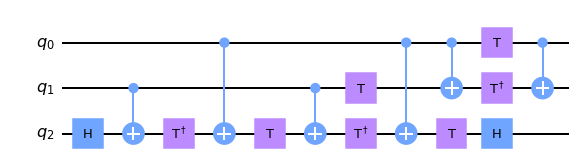

In [613]:
Q = QuantumCircuit(3)
Q.mcx([0,1],2)
QT = transpile(Q,basis_gates = ['t','tdg','h','cx'])
QT.draw("mpl")

In [616]:
def Toffoli(Controls, Target):
    
    QC = QuantumCircuit(N)
    QC.h(Target)
    QC.cx(Controls[1],Target)
    QC.tdg(Target),
    QC.cx(Controls[0],Target)
    QC.t(Target)
    QC.cx(Controls[1],Target)
    QC.t(Controls[1])
    QC.tdg(Target)
    QC.cx(Controls[0],Target)
    QC.cx(Controls[0],Controls[1])
    QC.t(Target)
    QC.t(Controls[0])
    QC.tdg(Controls[1])
    QC.h(Target)
    QC.cx(Controls[0],Controls[1])
    
    return QC

In [456]:
'''

This function takes four angles alpha, beta, delta and theta and returns the
unitary matrix according to page 8 of Elementary Gates in QC.

'''

def W(alpha,beta,delta,theta):
    A = np.exp(1j*(delta-alpha/2-beta/2))*np.cos(theta/2)
    B = -np.exp(1j*(delta-alpha/2+beta/2))*np.sin(theta/2)
    C = np.exp(1j*(delta+alpha/2-beta/2))*np.sin(theta/2)
    D = np.exp(1j*(delta+alpha/2+beta/2))*np.cos(theta/2)
    return np.matrix([[A,B],[C,D]])

In [457]:
'''

This function takes a gate (matrix) acting on the Qubit-th qubit and returns the matrix.

'''

def Multi_Qubit_Gate(Gate, Qubit):

    if Qubit == 0:
        
        M = sparse.csr_matrix(Gate) # Initializes the final matrix.
        
        for i in range(1,N):
        
            M = sparse.kron(M,identity(2)) # kronecker product.
        
        
    else:
        
        M = identity(2)
        
        for i in range(1,N):
            if i == Qubit:
                M = sparse.kron(M,Gate) # kronecker product.
            else:
                M = sparse.kron(M,identity(2)) # kronecker product.
        
    return M      

In [458]:
'''

Given a unitary matrix of the form [[A,B],[C,D]], the following fucntions returns
the angles alpha, beta, delta, theta
according to the decomposition of page 8 of Elementary Gates for QC.


'''
def Unitary_Angles(Matrix):

    A = Matrix[0,0]
    B = Matrix[0,1]
    C = Matrix[1,0]
    D = Matrix[1,1]
    
    def MyLog(Number):
        
        if Number.imag == 0:
            if Number < 0:
                return np.pi+np.log(Number)
            elif Number > 0:
                return np.log(Number)
        else:
            return np.log(Number)
        
    if A == 0: 
        
        theta = np.pi
        
        delta = (1/(2*1j))*MyLog(-B*C)

        beta = (1/1j)*MyLog(-B/C)
        
        alpha = 0
        
    elif B == 0:
        
        theta = 2*np.pi
        
        delta = (1/(2*1j))*MyLog(A*D)

        beta = 1j*MyLog(A/D)

        alpha = 0 
        
        if (W(alpha,beta,delta,theta)[1,1].real)*D > 0:
            pass
        else:
            theta = 0       
        
    else:  
        
        theta = -2*np.arctan(np.sqrt((-B*C)/(A*D)))
        
        delta = (1/(2*1j))*MyLog(A*D-B*C)
        
        beta = (1j/2)*MyLog(A/D)-(1j/2)*MyLog(-B/C)
        
        alpha = (1j/2)*MyLog(A/D)+(1j/2)*MyLog(-B/C)
        
    
        if (W(alpha,beta,delta,theta)[0,1].real)*B > 0:
            pass
        else:
            theta = - theta
        
    return alpha.real, beta.real, delta.real, theta.real

In [466]:
'''

This function takes a MCU gate and returns the two bit decomposition (Page 10, Elementary Gates for QC).

Input  : Gate list (e.g. Qf[-1])
Output : Circuit with two qubit decomposition.

'''
def Two_Qubit_Decomp(Gate_List):

    #Gate_List = Qf[-3]
    
    W = Gate_List[1] # The matrix is the first entry in the list.
    U = Unitary_Angles(W)
    alpha = U[0]
    beta  = U[1]
    delta = U[2]
    theta = U[3]
    
    
    I = identity(2)
    X = np.matrix([[0,1],[1,0]])

    
    '''
    
    The controlled phase gate will be decomposed using the algorithm described in Lemma 5.2
    page 11 of Elementary Gates for Quantum Computation.
    
    '''
    E = Rz_matrix(delta)*Phase_matrix(delta/2)
    
    A = Rz_matrix(alpha)*Ry_matrix(theta/2)
    
    B = Ry_matrix(-theta/2)*Rz_matrix(-(alpha+beta)/2)

    C = Rz_matrix((beta-alpha)/2)
    
    #CX = sparse.csr_matrix(np.matrix([[1,0,0,0],[0,1,0,0],[0,0,0,1],[0,0,1,0]]))
    
    
    qc = QuantumCircuit(N)
    
    if Gate_List[0] == 'MCU':
    
        control = Gate_List[2][0]
        target  = Gate_List[3]
        
    elif Gate_List[0] == 'CU':
        
        control = Gate_List[2][0]
        target  = Gate_List[2][1]
        
    else:
        
        print("Invalid gate encountered!")
    
    CPhase = Multi_Qubit_Gate(E, control).A  
    qc.unitary(CPhase,[i for i in range(N)],label = str('P')+'\n'+str(control))
    
    A_gate = Multi_Qubit_Gate(A, target).A  
    qc.unitary(A_gate,[i for i in range(N)],label = str('A')+'\n'+str(target))
    
    qc.cx(control,target)
    
    B_gate = Multi_Qubit_Gate(B, target).A
    qc.unitary(B_gate,[i for i in range(N)],label = str('B')+'\n'+str(target))
    
    
    qc.cx(control,target)
    
    C_gate = Multi_Qubit_Gate(C, target).A  
    qc.unitary(C_gate,[i for i in range(N)],label = str('C')+'\n'+str(target))  

    return qc, [
            ['P',E,control],
            ['A',A,target],
            ['CX',control, target],
            ['B',B,target],
            ['CX',control,target], 
            ['C',C,target]
                ]

In [27]:
'''

This function takes a matrix and returns the controlled W gate matrix (two qubits) .


'''


def Controlled_W(Matrix):
    
    P0 = np.matrix([[1,0],[0,0]])
    P1 = np.matrix([[0,0],[0,1]])
    I = np.identity(2)
    
    return np.kron(P0,I)+np.kron(P1,Matrix)

## Two qubit decomposition verification

In [586]:
CW1 = Qf[1]

alpha, beta, delta, theta = Unitary_Angles(Qf[0][1])

E = Rz_matrix(delta)*Phase_matrix(delta/2)

#C_Phase1 = CU(4,5,(Phase_matrix(delta)))

P = Phase_matrix(delta)
A = Rz_matrix(alpha)*Ry_matrix(theta/2)
    
B = Ry_matrix(-theta/2)*Rz_matrix(-(alpha+beta)/2)

C = Rz_matrix((beta-alpha)/2)
X = np.matrix([[0,1],[1,0]])

N = 6
c = 4
t = 5

Con_P = Multi_Qubit_Gate(E,c)#CU(c,t,P)

k = CU(c,t,CW1[1]).A-np.around(Con_P*Multi_Qubit_Gate(A,t)*CU(c,t,X)*Multi_Qubit_Gate(B,t)*CU(c,t,X)*Multi_Qubit_Gate(C,t).A,2)
#k2 = Multi_Qubit_Gate(A,5)*Multi_Qubit_Gate(B,5)*Multi_Qubit_Gate(C,5)
np.nonzero(k)

(array([], dtype=int64), array([], dtype=int64))

In [599]:
Toff = [
    ['H',2],
    ['CX',1,2],
    ['TD',2],
    ['CX',0,2],
    ['T',2],
    ['CX',1,2],
    ['T',1],
    ['TD',2],
    ['CX',0,2],
    ['CX',0,1],
    ['T',2],
    ['T',0],
    ['TD',1],
    ['H',2],
    ['CX',0,1]
]

Or = np.identity(2**3)
for gate in Toff:
    if gate[0] == 'T':
        Or = np.matmul(Or, T(gate[1]).A)
    elif gate[0] == 'TD':
        Or = np.matmul(Or, TDAG(gate[1]).A)
    elif gate[0] == 'H':
        Or = np.matmul(Or, Hadamard(np.pi/2, gate[1]).A)
    elif gate[0] == 'CX':
        Or = np.matmul(Or, CU(gate[1], gate[2], X).A)
np.around(Or.real,4)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 64 is different from 8)

In [621]:
Final_Circuit = QuantumCircuit(N)
Final_Gates   = []

def Toff(Controls, Target):
    return [
    ['H',Target],
    ['CX',Controls[1],Target],
    ['TD',Target],
    ['CX',Controls[0],Target],
    ['T',Target],
    ['CX',Controls[1],Target],
    ['T',Controls[1]],
    ['TD',Target],
    ['CX',Controls[0],Target],
    ['CX',Controls[0],Controls[1]],
    ['T',Target],
    ['T',Controls[0]],
    ['TD',Controls[1]],
    ['H',Target],
    ['CX',Controls[0],Controls[1]]
]

for gate in Qf:
    
    if gate[0] == 'MCX':
        
        if len(gate[2]) == 1: # This is a CX gate disguised as a MCX gate.
            
            qr_CX = QuantumCircuit(N)
            qr_CX.cx( gate[2][0], gate[3] )
            Final_Circuit = Final_Circuit.compose(qr_CX)
            Final_Gates = Final_Gates+[['CX',gate[2][0], gate[3]]]
            
        else: # This is a MCX gate with two control qubits i.e. Toffoli gate.
        

            Final_Circuit = Final_Circuit.compose(Toffoli(gate[2],gate[3]))
            
            Control = gate[2] # List
            Target  = gate[3] # Integer
            Final_Gates = Final_Gates + Toff(Control, Target)
        
    else: # MCU, CU
        
        Final_Circuit = Final_Circuit.compose(Two_Qubit_Decomp(gate)[0])
        Final_Gates = Final_Gates+Two_Qubit_Decomp(gate)[1]

In [622]:
#Final_Gates

In [602]:
Or = np.identity(2**N) 

for gate in Final_Gates:
    
    if gate[0] == 'T':
        Or = np.matmul(Or, T(gate[1]).A)
    elif gate[0] == 'TD':
        Or = np.matmul(Or, TDAG(gate[1]).A)
    elif gate[0] == 'H':
        Or = np.matmul(Or, Hadamard(np.pi/2, gate[1]).A)
    elif gate[0] == 'CX':
        Or = np.matmul(Or, CU(gate[1], gate[2], X).A)       
    elif gate[0] == 'RZ':     
        Or = Or*Rz(gate[1], gate[2]).A      
    else: # P, A, B, C

        Or = Or*Multi_Qubit_Gate(gate[1],gate[2]).A

In [608]:
M = Or
M = M/M[0,0]
#np.nonzero(MCU([0,1,2,3,4],5,X)-M)
sub1 = np.around(MCU([0,1,2,3,4],5,X)-M,2)
sub2 = np.around(MCX_qiskit([0,1,2,3,4],5)-M,2)
#np.nonzero(sub1)
np.around(M.real,2)
#np.around(MCX_qiskit([0,1,2,3,4],5)-MCU([0,1,2,3,4],5,X),2)

array([[ 1.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  1.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  , -0.17, ...,  0.  ,  0.  ,  0.  ],
       ...,
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ]])

In [619]:
len(Final_Gates)

606

In [620]:
len(Final_Circuit)#.draw("mpl")

606